<a href="https://colab.research.google.com/github/Rohan-crypt/DeepLearning/blob/main/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle albumentations opencv-python torchmetrics --quiet
from google.colab import files
files.upload()   # upload kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 12.1 MB/s eta 0:00:00


Saving kaggle.json to kaggle.json


In [ ]:
import zipfile
from pathlib import Path

DATA_DIR = Path("./data")
DATA_DIR.mkdir(exist_ok=True)

# ✅ Download RGB images
!kaggle datasets download -d pushkar007/vaihingendataimg -p {str(DATA_DIR)}

z = next(DATA_DIR.glob("*img*.zip"))
with zipfile.ZipFile(z, 'r') as f:
    f.extractall(DATA_DIR)
z.unlink()

# ✅ Download segmentation masks
!kaggle datasets download -d pushkar007/vaihingendataann -p {str(DATA_DIR)}

z = next(DATA_DIR.glob("*ann*.zip"))
with zipfile.ZipFile(z, 'r') as f:
    f.extractall(DATA_DIR)
z.unlink()

print("✅ Download + extract done")

Dataset URL: https://www.kaggle.com/datasets/pushkar007/vaihingendataimg
License(s): other
 98% 315M/322M [00:00<00:00, 457MB/s]
100% 322M/322M [00:00<00:00, 479MB/s]
Dataset URL: https://www.kaggle.com/datasets/pushkar007/vaihingendataann
License(s): other
  0% 0.00/7.05M [00:00<?, ?B/s]
100% 7.05M/7.05M [00:00<00:00, 504MB/s]
✅ Download + extract done


In [ ]:
from pathlib import Path

DATA_DIR = Path("./data")

IMG_TRAIN = DATA_DIR/"img_dir/train"
IMG_VAL   = DATA_DIR/"img_dir/val"
MASK_TRAIN = DATA_DIR/"ann_dir/train"
MASK_VAL   = DATA_DIR/"ann_dir/val"

train_imgs = sorted(list(IMG_TRAIN.glob("*.png")))
train_masks = sorted(list(MASK_TRAIN.glob("*.png")))
val_imgs = sorted(list(IMG_VAL.glob("*.png")))
val_masks = sorted(list(MASK_VAL.glob("*.png")))

print("Train images:", len(train_imgs))
print("Train masks :", len(train_masks))
print("Val images  :", len(val_imgs))
print("Val masks   :", len(val_masks))

Train images: 344
Train masks : 344
Val images  : 398
Val masks   : 418


In [ ]:
import cv2
import numpy as np

def read_mask_raw(p):
    m = cv2.imread(str(p), cv2.IMREAD_UNCHANGED)
    if m.ndim == 3:
        m = cv2.cvtColor(m, cv2.COLOR_BGR2GRAY)
    return m.astype(np.int64)

def collect_unique_labels(paths):
    uniq = set()
    for p in paths:
        uniq.update(np.unique(read_mask_raw(p)))
    return sorted(uniq)

unique_labels = collect_unique_labels(train_masks + val_masks)
print("Unique labels:", unique_labels)

IGNORE_INDEX = 255 if 255 in unique_labels else None

known = [x for x in unique_labels if x != IGNORE_INDEX]
sorted_known = sorted(known)
label_to_idx = {lab: i for i, lab in enumerate(sorted_known)}
NUM_CLASSES = len(label_to_idx)
print("Mapping:", label_to_idx, " → NUM_CLASSES =", NUM_CLASSES)

maxval = max(unique_labels)

lut = np.full((maxval+1,), -1, dtype=np.int64)
for lab, idx in label_to_idx.items():
    lut[lab] = idx

Unique labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
Mapping: {np.int64(0): 0, np.int64(1): 1, np.int64(2): 2, np.int64(3): 3, np.int64(4): 4, np.int64(5): 5, np.int64(6): 6}  → NUM_CLASSES = 7


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 256
BATCH_SIZE = 4
MAX_EPOCHS = 100
LR = 2e-3

def read_img(path):
    img = cv2.imread(str(path), cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def map_mask_labels(mask):
    m = mask.copy()
    inrange = m <= maxval
    m[inrange] = lut[m[inrange]]
    if IGNORE_INDEX is not None:
        m[mask == IGNORE_INDEX] = IGNORE_INDEX
    return m

train_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.Normalize(),
    ToTensorV2()
])

valid_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(),
    ToTensorV2()
])

class SegDataset(Dataset):
    def __init__(self, imgs, masks, tfms):
        self.imgs = imgs
        self.masks = masks
        self.tfms = tfms

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = read_img(self.imgs[idx])
        mask = read_mask_raw(self.masks[idx])
        mask = map_mask_labels(mask)
        out = self.tfms(image=img, mask=mask)
        return out["image"], out["mask"].long()

train_ds = SegDataset(train_imgs, train_masks, train_tfms)
val_ds   = SegDataset(val_imgs,   val_masks,   valid_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE)

In [ ]:
from torch import nn

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.ReLU()
        )
    def forward(self, x): return self.net(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x): return self.conv(self.pool(x))

class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, in_ch//2, 2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size(2)-x1.size(2)
        diffX = x2.size(3)-x1.size(3)
        x1 = nn.functional.pad(x1,[diffX//2,diffX-diffX//2,
                                   diffY//2,diffY-diffY//2])
        return self.conv(torch.cat([x2,x1],1))

class UNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        base=32
        self.inc=DoubleConv(3,base)
        self.down1=Down(base,base*2)
        self.down2=Down(base*2,base*4)
        self.down3=Down(base*4,base*8)
        self.down4=Down(base*8,base*16)
        self.up1=Up(base*16,base*8)
        self.up2=Up(base*8,base*4)
        self.up3=Up(base*4,base*2)
        self.up4=Up(base*2,base)
        self.outc=nn.Conv2d(base,n_classes,1)
    def forward(self,x):
        x1=self.inc(x)
        x2=self.down1(x1)
        x3=self.down2(x2)
        x4=self.down3(x3)
        x5=self.down4(x4)
        x=self.up1(x5,x4)
        x=self.up2(x,x3)
        x=self.up3(x,x2)
        x=self.up4(x,x1)
        return self.outc(x)

# ✅ safe initialization
try:
    model = UNet(NUM_CLASSES).to(DEVICE)
except:
    print("⚠ CUDA failed, using CPU")
    DEVICE="cpu"
    model = UNet(NUM_CLASSES).to(DEVICE)

In [ ]:
from torchmetrics.classification import MulticlassJaccardIndex, MulticlassF1Score
import numpy as np
import torch

# Loss: ignore IGNORE_INDEX (e.g., label 255)
ignore_loss = IGNORE_INDEX if IGNORE_INDEX is not None else -100
loss_fn = nn.CrossEntropyLoss(ignore_index=ignore_loss)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Metrics (also ignore IGNORE_INDEX)
miou = MulticlassJaccardIndex(
    num_classes=NUM_CLASSES,
    ignore_index=IGNORE_INDEX
).to(DEVICE)

dice = MulticlassF1Score(
    num_classes=NUM_CLASSES,
    average='macro',
    ignore_index=IGNORE_INDEX
).to(DEVICE)

for epoch in range(1, MAX_EPOCHS + 1):
    model.train()
    losses = []

    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        out = model(x)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    # Evaluate
    model.eval()
    miou.reset(); dice.reset()

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            pred = torch.argmax(out, dim=1)
            miou.update(pred, y)
            dice.update(pred, y)

    print(f"Epoch {epoch:02d} | "
          f"Loss={np.mean(losses):.4f} | "
          f"mIoU={miou.compute():.4f} | "
          f"Dice={dice.compute():.4f}")

Epoch 01 | Loss=1.5671 | mIoU=0.2150 | Dice=0.3075
Epoch 02 | Loss=0.9979 | mIoU=0.2583 | Dice=0.3512
Epoch 03 | Loss=0.9623 | mIoU=0.2870 | Dice=0.3790
Epoch 04 | Loss=0.9063 | mIoU=0.2833 | Dice=0.3762
Epoch 05 | Loss=0.9068 | mIoU=0.2834 | Dice=0.3790
Epoch 06 | Loss=0.8897 | mIoU=0.2804 | Dice=0.3745
Epoch 07 | Loss=0.8884 | mIoU=0.3033 | Dice=0.4011
Epoch 08 | Loss=0.8756 | mIoU=0.3167 | Dice=0.4166
Epoch 09 | Loss=0.8597 | mIoU=0.3227 | Dice=0.4239
Epoch 10 | Loss=0.8574 | mIoU=0.3189 | Dice=0.4284
Epoch 11 | Loss=0.8530 | mIoU=0.3183 | Dice=0.4192
Epoch 12 | Loss=0.8435 | mIoU=0.3071 | Dice=0.4148
Epoch 13 | Loss=0.8418 | mIoU=0.3059 | Dice=0.4201
Epoch 14 | Loss=0.8528 | mIoU=0.3156 | Dice=0.4259
Epoch 15 | Loss=0.8251 | mIoU=0.3285 | Dice=0.4370
Epoch 16 | Loss=0.8233 | mIoU=0.3453 | Dice=0.4547
Epoch 17 | Loss=0.8173 | mIoU=0.3358 | Dice=0.4454
Epoch 18 | Loss=0.8090 | mIoU=0.3422 | Dice=0.4499
Epoch 19 | Loss=0.8201 | mIoU=0.3424 | Dice=0.4541
Epoch 20 | Loss=0.8221 | mIoU=0

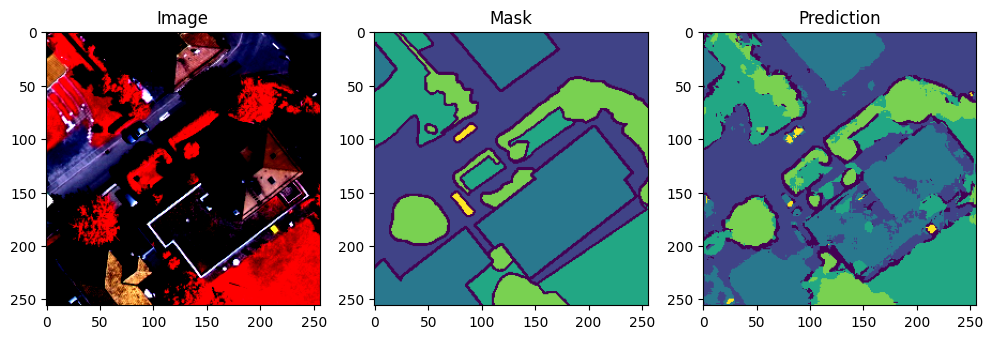

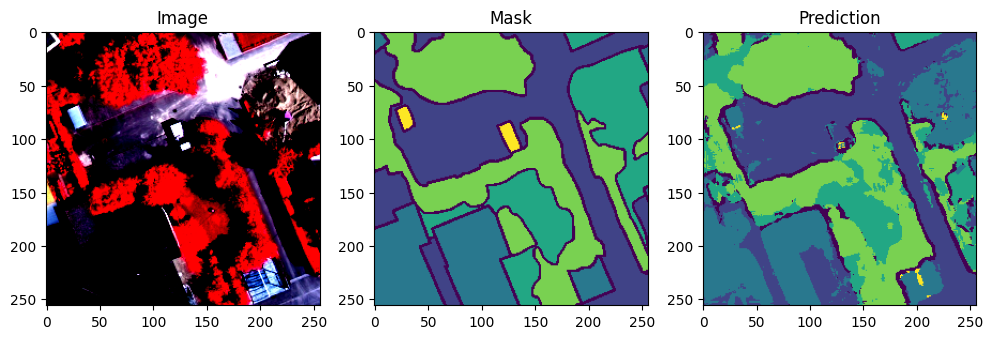

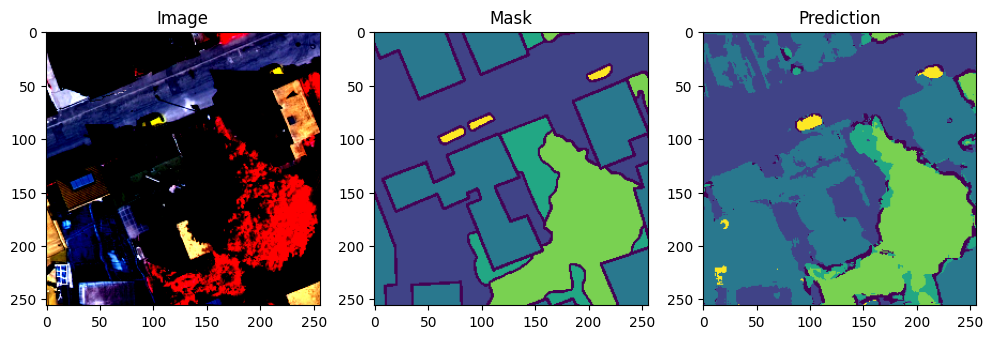

In [ ]:
import matplotlib.pyplot as plt

def show_preds(n=3):
    model.eval()
    shown = 0

    for x, y in val_loader:
        x = x.to(DEVICE)

        with torch.no_grad():
            pred = torch.argmax(model(x), dim=1).cpu().numpy()

        imgs = x.cpu().permute(0, 2, 3, 1).numpy()
        masks = y.numpy()

        for i in range(len(imgs)):
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.title("Image")
            plt.imshow(imgs[i])

            plt.subplot(1, 3, 2)
            plt.title("Mask")
            plt.imshow(masks[i])

            plt.subplot(1, 3, 3)
            plt.title("Prediction")
            plt.imshow(pred[i])

            plt.show()

            shown += 1
            if shown >= n:
                return

show_preds()
